In [1]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision enabled with policy: {policy}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
    except RuntimeError as e:
        print(f"Failed to set virtual device configuration: {e}")

2024-12-31 19:04:49.619341: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 19:04:49.672444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 19:04:49.672490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 19:04:49.673660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 19:04:49.682339: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
Mixed precision enabled with policy: mixed_float16


2024-12-31 19:04:55.161238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:04:55.300678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:04:55.300758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:04:55.301357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


In [3]:
import sys
# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
from utils import (
    create_diffusion_model,
    train_diffusion_model,
    string_with_tashkeel_vectorizer_per_batch,
    calculate_meter_accuracy,
    validate_data
)

# Configure visualization settings
%matplotlib inline


In [19]:
# Enable mixed precision
policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision enabled with policy: {policy}")

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth enabled for GPU: {gpu}")
    except RuntimeError as e:
        print(f"Error enabling memory growth for GPU {gpu}: {e}")
else:
    print("No GPU found.")

Mixed precision enabled with policy: mixed_float16
Memory growth enabled for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# Paths
processed_data_path = '../data/processed/processed_taweel_data.csv'
diffusion_output_dir = '../models/diffusion'
transformer_output_dir = '../models/transformers'
os.makedirs(diffusion_output_dir, exist_ok=True)
os.makedirs(transformer_output_dir, exist_ok=True)

# Load processed data
print("Loading processed data...")
processed_df = pd.read_csv(processed_data_path, encoding='utf-8-sig')
print(f"Processed data loaded with {len(processed_df)} records.")

# For testing, use a subset or full dataset
subset = True  # Toggle this for subset testing or full dataset training
if subset:
    print("Using subset for testing...")
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset = train_df.sample(n=100, random_state=42)  # Adjust as needed
    valid_subset = valid_df.sample(n=20, random_state=42)
else:
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset, valid_subset = train_df, valid_df

print(f"Training records: {len(train_subset)}; Validation records: {len(valid_subset)}")


Loading processed data...
Processed data loaded with 103441 records.
Using subset for testing...
Training records: 100; Validation records: 20


In [6]:
# Define model parameters
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}

# Input shape
max_bayt_len = 1000  # Matches preprocessing
encoding_dim = 8
input_shape = (max_bayt_len, encoding_dim)

In [7]:

# =============================================================================
# Diffusion Model
# =============================================================================

print("Creating diffusion model...")
diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)

# Prepare data
# Vectorize training and validation data
print("Vectorizing training and validation data...")
X_train_enc = string_with_tashkeel_vectorizer_per_batch(pd.Series(train_subset['text']), max_bayt_len)
Y_train_enc = X_train_enc.copy()  # Target is clean data

X_valid_enc = string_with_tashkeel_vectorizer_per_batch(pd.Series(valid_subset['text']), max_bayt_len)
Y_valid_enc = X_valid_enc.copy()

# Ensure that the vectorizer returns numpy arrays
X_train_enc = np.array(X_train_enc)
Y_train_enc = np.array(Y_train_enc)
X_valid_enc = np.array(X_valid_enc)
Y_valid_enc = np.array(Y_valid_enc)

# Train diffusion model with smaller batch size and gradient accumulation
batch_size = 8  # Adjust based on GPU memory
epochs = 50
print("Training diffusion model...")
diffusion_history = train_diffusion_model(
    model=diffusion_model,
    X_train=X_train_enc,
    Y_train=Y_train_enc,
    X_valid=X_valid_enc,
    Y_valid=Y_valid_enc,
    epochs=epochs,
    batch_size=batch_size,
    output_dir=diffusion_output_dir
)


Creating diffusion model...


2024-12-31 15:39:18.718104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 15:39:18.718300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 15:39:18.718382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 15:39:18.925517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 15:39:18.925670: I external/local_xla/xla/stream_executor

Model: "DiffusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 1000, 8)]            0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 1000, 8)              16        ['input_layer[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_0 (Mu  (None, 1000, 8)              17928     ['layer_normalization[0][0]', 
 ltiHeadAttention)                                                   'layer_normalization[0][0]'] 
                                                                                     

2024-12-31 15:39:30.871361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


 5/13 [==========>...................] - ETA: 1s - loss: 0.8774 - mae: 0.7975  

2024-12-31 15:39:33.723823: I external/local_xla/xla/service/service.cc:168] XLA service 0x7faf9108a640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-31 15:39:33.723906: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-31 15:39:33.798453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735677574.159907    2719 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - ETA: 0s - loss: 0.6299 - mae: 0.6562
Epoch 1: val_mae improved from inf to 0.41714, saving model to ../models/diffusion/diffusion_model_epoch_01_val_mae_0.4171.h5


/home/tarek/miniconda3/envs/baytdiffuser_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 21s 762ms/step - loss: 0.6299 - mae: 0.6562 - val_loss: 0.2256 - val_mae: 0.4171
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.1461 - mae: 0.3096
Epoch 2: val_mae improved from 0.41714 to 0.23362, saving model to ../models/diffusion/diffusion_model_epoch_02_val_mae_0.2336.h5
13/13 [==============================] - 3s 198ms/step - loss: 0.1461 - mae: 0.3096 - val_loss: 0.0927 - val_mae: 0.2336
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.0699 - mae: 0.1966
Epoch 3: val_mae improved from 0.23362 to 0.15761, saving model to ../models/diffusion/diffusion_model_epoch_03_val_mae_0.1576.h5
13/13 [==============================] - 3s 202ms/step - loss: 0.0699 - mae: 0.1966 - val_loss: 0.0459 - val_mae: 0.1576
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.0378 - mae: 0.1294
Epoch 4: val_mae improved from 0.15761 to 0.10320, saving model to ../models/diffusion/diffusion_model_epoch_

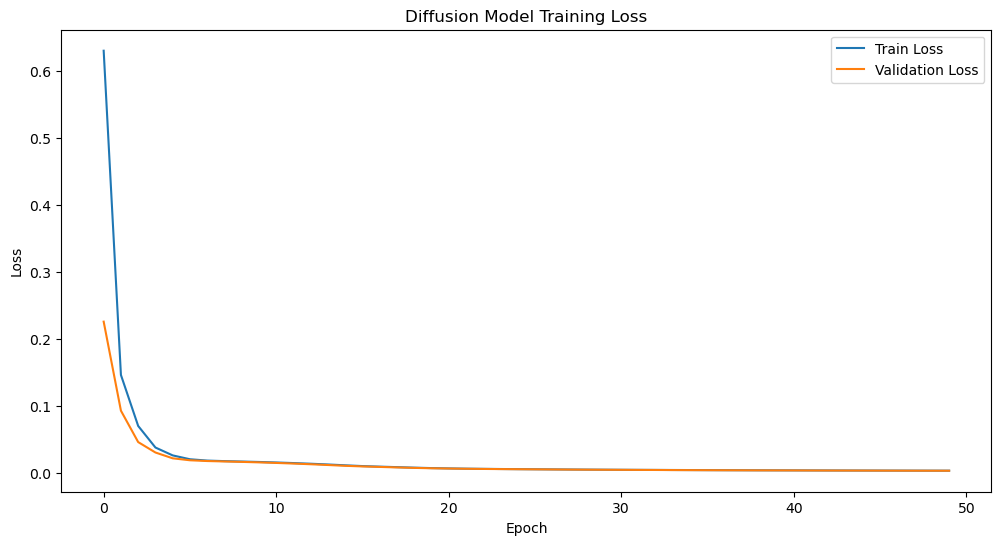

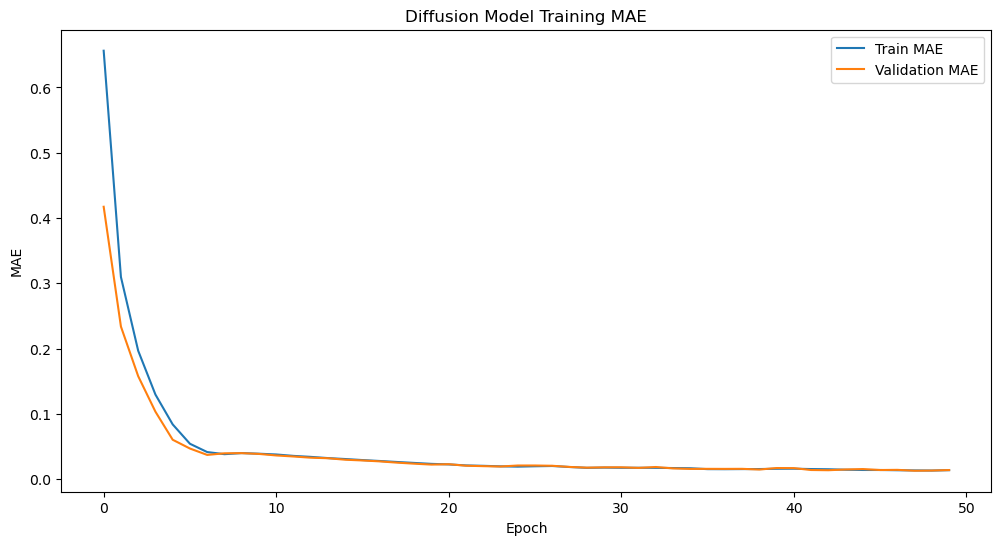

In [8]:
# =============================================================================
# Plot Training History
# =============================================================================

plt.figure(figsize=(12, 6))
plt.plot(diffusion_history.history['loss'], label='Train Loss')
plt.plot(diffusion_history.history['val_loss'], label='Validation Loss')
plt.title('Diffusion Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(diffusion_history.history['mae'], label='Train MAE')
plt.plot(diffusion_history.history['val_mae'], label='Validation MAE')
plt.title('Diffusion Model Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [ ]:
# =============================================================================
# Save Final Diffusion Model
# =============================================================================

diffusion_final_path = os.path.join(diffusion_output_dir, 'diffusion_model_final.h5')
diffusion_model.save(diffusion_final_path, include_optimizer=False)
print(f"Diffusion model saved to {diffusion_final_path}")

In [7]:
def load_diffusion_model_from_file(model_path, input_shape, model_params):
    """
    Loads the saved diffusion model from file if available, else creates a new one.

    Args:
        model_path (str): Path to the saved diffusion model file.
        input_shape (tuple): Input shape for creating a new model if the file doesn't exist.
        model_params (dict): Parameters for creating a new diffusion model.

    Returns:
        tf.keras.Model: Loaded or newly created diffusion model.
    """
    if os.path.exists(model_path):
        print(f"Loading diffusion model from {model_path}...")
        model = tf.keras.models.load_model(model_path, compile=False)
        print("Diffusion model loaded successfully.")
    else:
        print(f"Model not found at {model_path}. Creating a new diffusion model...")
        model = create_diffusion_model(input_shape, model_params)
    return model


In [8]:
# Define path to saved diffusion model
diffusion_final_path = os.path.join(diffusion_output_dir, 'diffusion_model_final.h5')

# Load or create the diffusion model
print("Checking for saved diffusion model...")
diffusion_model = load_diffusion_model_from_file(
    model_path=diffusion_final_path,
    input_shape=input_shape,
    model_params=diffusion_model_params
)


Checking for saved diffusion model...
Loading diffusion model from ../models/diffusion/diffusion_model_final.h5...


2024-12-31 19:05:29.696781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:05:29.696942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:05:29.696985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:05:29.880455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 19:05:29.880502: I tensorflow/core/common_runtime/gpu/gpu

Diffusion model loaded successfully.


In [9]:
# =============================================================================
# Transformer Model Training
# =============================================================================

import pandas as pd
from transformers import AutoTokenizer
from utils import create_seq2seq_transformer, train_seq2seq_transformer

# Define parameters
model_name = 't5-small'  # Recommended: Use a seq2seq model like T5
max_length = 256
batch_size = 4  # Adjust based on your GPU memory
epochs = 50
output_dir = './seq2seq_output'
os.makedirs(output_dir, exist_ok=True)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example data: Replace these with your actual paired datasets
# Ensure that each modern poem has a corresponding classical poem
train_subset = pd.DataFrame({
    'text': ["Modern poem 1...", "Modern poem 2...", "..."],  # Replace with actual modern poems
    'classical_text': ["Classical poem 1...", "Classical poem 2...", "..."]  # Replace with corresponding classical poems
})

valid_subset = pd.DataFrame({
    'text': ["Modern poem A...", "Modern poem B...", "..."],  # Replace with actual modern poems
    'classical_text': ["Classical poem A...", "Classical poem B...", "..."]  # Replace with corresponding classical poems
})

train_texts = train_subset['text'].tolist()
train_classical_texts = train_subset['classical_text'].tolist()

valid_texts = valid_subset['text'].tolist()
valid_classical_texts = valid_subset['classical_text'].tolist()

# Create the model
vocab_size = tokenizer.vocab_size  # Or len(tokenizer) depending on tokenizer implementation
model = create_seq2seq_transformer(model_name, max_length, vocab_size)

# Train the model
model, history = train_seq2seq_transformer(
    model=model,
    tokenizer=tokenizer,
    train_texts=train_texts,
    train_classical_texts=train_classical_texts,
    valid_texts=valid_texts,
    valid_classical_texts=valid_classical_texts,
    max_length=max_length,
    epochs=epochs,
    batch_size=batch_size,
    output_dir=output_dir
)

# Save the final model
final_model_path = os.path.join(output_dir, "seq2seq_transformer_model_final.h5")
model.save(final_model_path, include_optimizer=True)
print(f"Final seq2seq Transformer model saved to {final_model_path}")

# Save the tokenizer
tokenizer_output_path = os.path.join(output_dir, "tokenizer")
tokenizer.save_pretrained


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TypeError: train_seq2seq_transformer() got an unexpected keyword argument 'train_classical_texts'

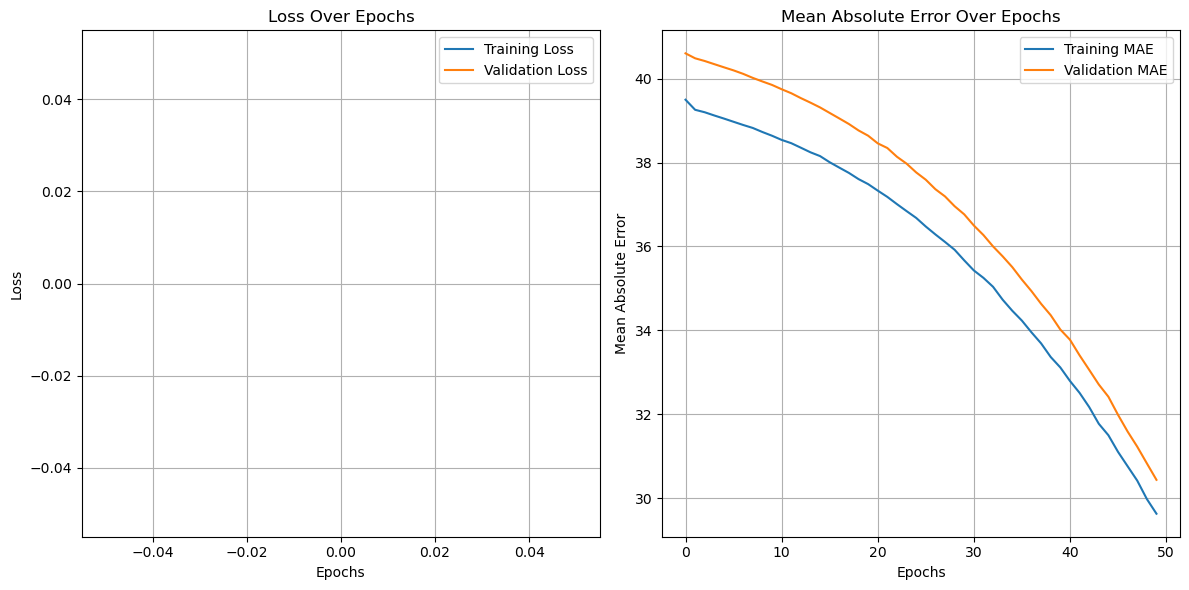

In [12]:
# =============================================================================
# Plot Training History
# =============================================================================

def plot_training_history(history):
    """
    Plot training and validation metrics for the training history.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()  # Corrected here
    plt.grid(True)
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()  # Corrected here
    plt.grid(True)
    
    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [ ]:

# =============================================================================
# Transformer Model Training _ TEST
# =============================================================================

# Model parameters
transformer_model_name = 'aubmindlab/bert-base-arabertv2'
#transformer_model_name = 'distilbert-base-uncased'

max_length = 128
batch_size = 4
epochs = 50
transformer_output_dir = './transformer_output'
os.makedirs(transformer_output_dir, exist_ok=True)

# Load tokenizer and transformer
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
transformer = TFAutoModel.from_pretrained(transformer_model_name)

# Tokenize text
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_texts(train_subset['text'].tolist(), tokenizer, max_length)
valid_encodings = tokenize_texts(valid_subset['text'].tolist(), tokenizer, max_length)

# TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_encodings['input_ids']
)).shuffle(buffer_size=1024).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': valid_encodings['input_ids'],
        'attention_mask': valid_encodings['attention_mask']
    },
    valid_encodings['input_ids']
)).batch(batch_size)

# Callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join(transformer_output_dir, "best_model.h5"),
        monitor='val_loss', save_best_only=True, verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    TensorBoard(log_dir=os.path.join(transformer_output_dir, "logs"))
]

# Train model with GPU fallback
try:
    with tf.device('/GPU:0'):
        print("Training transformer model on GPU...")
        history = transformer.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
except tf.errors.ResourceExhaustedError:
    print("GPU memory exhausted. Falling back to CPU...")
    with tf.device('/CPU:0'):
        history = transformer.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

# Save model
transformer.save_pretrained(transformer_output_dir)
print(f"Transformer model saved to {transformer_output_dir}")


In [10]:

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(transformer_history.history['loss'], label='Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(transformer_history.history['mae'], label='Train MAE')
plt.plot(transformer_history.history['val_mae'], label='Validation MAE')
plt.title('Transformer Model Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

NameError: name 'transformer_history' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:

# Save transformer model
transformer_final_path = os.path.join(transformer_output_dir, 'transformer_model_test_final.h5')
transformer_model.save(transformer_final_path)
print(f"Transformer model saved to {transformer_final_path}")
